In [1]:
%load_ext autoreload
%autoreload 2

# Functions & Imports

In [2]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), os.pardir))

import numpy as np
import pandas as pd
import tensorflow as tf
from Tools.leica_tools import RawLoader
from Tools.db_tools import DbManager
from functools import partial
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

import keras
from keras.api.optimizers import Adam
from keras.api.models import Model, load_model
from keras.api.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from keras.api.losses import CategoricalCrossentropy
from keras.api.metrics import CategoricalAccuracy
from keras.api.utils import plot_model

# Cell count classification

In [3]:
def cell_count(inputs, cls_label):
    conv1 = Conv2D(32, (3, 3), activation='relu', name=cls_label + '_conv1')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2), name=cls_label + '_pool1')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', name=cls_label + '_conv2')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2), name=cls_label + '_pool2')(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', name=cls_label + '_conv3')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2), name=cls_label + '_pool3')(conv3)

    flatten = Flatten(name=cls_label + '_flatten')(pool3)

    dense1 = Dense(512, activation='relu', name=cls_label + '_dense1')(flatten)
    dropout1 = Dropout(0.5, name=cls_label + '_dropout1')(dense1)

    dense2 = Dense(256, activation='relu', name=cls_label + '_dense2')(dropout1)
    dropout2 = Dropout(0.5, name=cls_label + '_dropout2')(dense2)

    dense3 = Dense(128, activation='relu', name=cls_label + '_dense3')(dropout2)
    dropout3 = Dropout(0.5, name=cls_label + '_dropout3')(dense3)

    output = Dense(5, activation='softmax', name=cls_label + '_output')(dropout3)

    model = Model(inputs=inputs, outputs=output, name=cls_label + '_model')

    return model

# Depending on how many labels need to be predicted from the droplets, several CNNs will be added to the model in parallel
def get_model(labels):
    input = Input(shape=(128,128,4), name='cell_count_input')
    models = [cell_count(input, label) for label in labels]
    model = Model(inputs=[input], outputs=[m.output for m in models])
    model.compile(optimizer=Adam(),
                  loss={label+'_output': CategoricalCrossentropy() for label in labels},
                  metrics={label+'_output': CategoricalAccuracy() for label in labels})
    return model

Building the tensorflow dataset from .tfrecord files. Importantly, not all frames from a droplet database can be used. 
Only droplets that are fully annotated and were not excluded as outliers should be added to teh training dataset.

In [4]:
#Build dataset from annotated data from multiple experiments
def build_dataset(expIDs, annotation_keys):
    dataset = dbm.get_datasets(expIDs, shuffle=True)
    
    # Scan through the droplets which droplets contain annotations and which droplets need to be excluded
    filter_dfs = []
    ann_dfs = []
    for expID in expIDs:
        drop_register = RawLoader(expID).get_droplet_df()
        ann_df = dbm.get_wps(expID, filter_annotations='full').set_index('GlobalID').filter(annotation_keys)
        ann_df = ann_df[ann_df.apply(lambda row: (row != 10).all(), axis=1)].copy()
        ann_df[ann_df > 4] = 4


        filter_df = pd.Series({ID: (ID in ann_df.index) for ID in drop_register.index}, name='include').to_frame()
        filter_df.set_index(pd.MultiIndex.from_product([[expID], filter_df.index]), inplace=True)
        filter_dfs.append(filter_df)

        ann_df.set_index(pd.MultiIndex.from_product([[expID], ann_df.index]), inplace=True)
        ann_dfs.append(ann_df)
    filter_df = pd.concat(filter_dfs)
    ann_df = pd.concat(ann_dfs)

    filtered_dataset = dataset.filter(partial(filter_dataset, filter_df=filter_df))
    annotated_dataset = filtered_dataset.map(partial(prepare_data, annotations=ann_df))
    return annotated_dataset

def filter_dataset(element, filter_df):
    return tf.py_function(lambda x, i: filter_df.loc[(x.numpy().decode(), i.numpy()), 'include'], [element['expID'], element['GlobalID']], tf.bool)
    
def prepare_data(element, annotations):
    globalID = element['GlobalID']
    image = tf.cast(element['frame'], tf.float32)
    image = tf.math.log(image+1)
    image = (image - tf.reduce_min(image)) /(tf.reduce_max(image) - tf.reduce_min(image))
    element['cell_count_input'] = image
    
    outputs = {}
    for ann_key in annotations.columns:
        label = tf.py_function(lambda x, i: annotations.loc[(x.numpy().decode(), i.numpy()), ann_key], [element['expID'], globalID], tf.int64)
        label.set_shape(())
        label = tf.cast(tf.one_hot(label, 5), tf.int64)
        outputs[ann_key + '_output'] = label
    return element, outputs
    

    
    

In [5]:
dbm = DbManager()

In [6]:
expIDs = ['NKIP_FA_063','NKIP_FA_066', 'NKIP_FA_069', 'NKIP_FA_070']
annotation_keys = ['Target', 'Effector', 'dead_Target', 'dead_Effector']
dataset = build_dataset(expIDs, annotation_keys)
validation_dataset = build_dataset(['NKIP_FA_064'], annotation_keys)

In [7]:
n_elements = dataset.reduce(tf.constant(0), lambda a,b: a+1).numpy()
n_elements_val = validation_dataset.reduce(tf.constant(0), lambda a,b: a+1).numpy()
print(f'{n_elements} frames in train dataset')
print(f'{n_elements_val} frames in test dataset')

3526 frames in train dataset
1135 frames in test dataset


In [8]:
train_final = dataset.repeat(8).batch(32)
test_final = validation_dataset.repeat(8).batch(32)

In [9]:
model = get_model(annotation_keys)

In [11]:
model = keras.models.load_model(os.path.join(os.getenv('MODEL_DIR'), 'cell_count', 'cell_count_v2.h5'))
labels = annotation_keys
model.compile(optimizer=Adam(),
              loss={label+'_output': CategoricalCrossentropy() for label in labels},
              metrics={label+'_output': CategoricalAccuracy() for label in labels})

In [12]:
#model_arch = plot_model(model, to_file='cell_count.png', dpi=100)

In [10]:
model.fit(train_final, validation_data=test_final, batch_size=32, steps_per_epoch=110, epochs=8, validation_steps=35)

Epoch 1/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 109s 966ms/step - Effector_output_categorical_accuracy: 0.6557 - Target_output_categorical_accuracy: 0.4184 - dead_Effector_output_categorical_accuracy: 0.8314 - dead_Target_output_categorical_accuracy: 0.7675 - loss: 3.5731 - val_Effector_output_categorical_accuracy: 0.8821 - val_Target_output_categorical_accuracy: 0.6598 - val_dead_Effector_output_categorical_accuracy: 0.9688 - val_dead_Target_output_categorical_accuracy: 0.9152 - val_loss: 1.7027
Epoch 2/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 107s 982ms/step - Effector_output_categorical_accuracy: 0.7763 - Target_output_categorical_accuracy: 0.7474 - dead_Effector_output_categorical_accuracy: 0.8855 - dead_Target_output_categorical_accuracy: 0.8681 - loss: 1.9392 - val_Effector_output_categorical_accuracy: 0.8830 - val_Target_output_categorical_accuracy: 0.7045 - val_dead_Effector_output_categorical_accuracy: 0.9688 - val_dead_Target_output_categorical_accuracy: 0.9312 - val_loss: 1.5453
Epoch 3/8
110/

In [11]:
model.save(os.path.join(os.getenv('MODEL_DIR'),'cell_count', 'cell_count_v3.h5'))

# Evaluate performance

In [12]:
dbm = DbManager()
expIDs = [ 'NKIP_FA_064']
annotation_keys = ['Target', 'Effector', 'dead_Target', 'dead_Effector']
dataset = build_dataset(expIDs, annotation_keys)

In [20]:
model = load_model(os.path.join(os.getenv('MODEL_DIR'), 'cell_count', 'cell_count_v3.h5'))
predictions = model.predict(dataset.batch(32))
y_pred = pd.DataFrame(np.argmax(np.array(predictions), axis=-1).transpose(), columns=annotation_keys)

y_true = y_pred.copy()
for i, (element, output) in enumerate(dataset.as_numpy_iterator()):
    y_true.iloc[i, :] = np.array([np.argmax(output[f'{key}_output']) for key in annotation_keys])

36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 441ms/step


/Users/fauberma/mambaforge/envs/phenotyping/lib/python3.12/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-09-20 13:08:27.731479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-20 13:08:40.974907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Text(0.5, 0, 'Predicted number of cells')

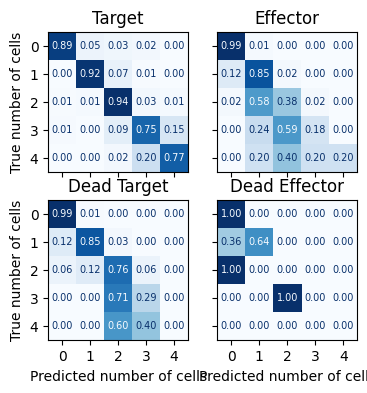

In [21]:
ann2title = {'Target': 'Target',
             'Effector': 'Effector',
             'dead_Target': 'Dead Target',
             'dead_Effector': 'Dead Effector'}

fig,axs = plt.subplots(ncols=2, nrows=2, figsize=(4,4), dpi=100, sharey=True, sharex=True)
for ax, ann in zip(axs.flatten(), annotation_keys):
    ConfusionMatrixDisplay.from_predictions(y_true=y_true[ann], y_pred=y_pred[ann], labels=np.arange(5),cmap='Blues',ax=ax,colorbar=False, normalize='true', values_format='.2f', text_kw={'fontsize': 7})
    ax.grid(False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(ann2title[ann])

axs.flatten()[0].set_ylabel('True number of cells')
axs.flatten()[2].set_ylabel('True number of cells')
axs.flatten()[2].set_xlabel('Predicted number of cells')
axs.flatten()[3].set_xlabel('Predicted number of cells')